# Using Wearable Sensors to Detect Nurses Stress in Real-Time
## CE888-7-SP : Data Science and Decision Making
### Assignment # 02

----------------------
### Name: Hassaan-ur-Rahman
### Student ID: 2208526
----------------------

### Introduction

The main objective of this research was to obtain a diverse dataset using multimodal sensors for the purpose of continuously detecting stress levels among nurses in a hospital environment. The authors emphasized the highly stressful nature of nursing.

Data was collected from 15 nurses aged 30-35 years old in a hospital setting, which included the collection of physiological signals (such as electrocardiogram and electrodermal activity), motion signals (such as accelerometer), and audio signals (such as speech). Additionally, self-reported stress levels were obtained from the nurses through the use of a questionnaire in the form of survey.

-------------------

### Steps performed Previously
- 1. Data Unzip (Done manually)
- 2. Data Combine/Merge
- 3. Resampling (Undersampling - Converting to the minimum freq value)
- 4. Drop null values.
- 5. Matching timezone of nurses and survey data.
- 6. Visualization of the data.
- 7. Modeling
- 8. Find the best features.
- 9. Co-relation between the features.

### Things added for part 2:
- 1. Time series plot
- 2. Heatmap for co-relation
- 3. Test and Train 70 - 30 Split
- 4. New Models with test and train data
- 5. Cross Validation
- 6. Parameter optimization
- 7. Model Comparison
- 8. Confusion Matrix

-----------------

### Data Combine/Merge

#### Importing lib

In [1]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
from dataProcessing import preProcessingData, resampling
import seaborn as sns
from datetime import datetime,timedelta
from mpl_toolkits.mplot3d import Axes3D
import os
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.utils import resample
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV
from scipy.stats import kurtosis,skew,entropy
from sklearn.metrics import confusion_matrix

###### Data Path

In [2]:
data_path = "D:/University of Essex/Term 2/CE888-7 Data Science & Decision Making/Assignments/Assignment 1/Stress_dataset/"
survey_path = "D:/University of Essex/Term 2/CE888-7 Data Science & Decision Making/Assignments/Assignment 1/"

##### While merging we will do the pre-processing which includes the resampling and forward fill.

##### We will loop over all the
- nurses
- records of a nurse
- data files

In [3]:
combinedNursesData = pd.DataFrame()
count = 0
#loop over all the nurses in the dataset
for nurse_folder in os.listdir(data_path):
    count = count+1
    print('--------------------------------------')
    print('Nurse:', count, '/15: ',nurse_folder)
    
    #define the path of the current nurse's folder
    nurse_path = os.path.join(data_path, nurse_folder)
    nursesRecords = pd.DataFrame()
    
    #loop over all the records in the current nurse's folder
    for record_folder in os.listdir(nurse_path):
        print('Merging Folder: ', record_folder)
        record_path = os.path.join(nurse_path, record_folder)
        
        #loop over all the data files for the current record
        for file_name in ["ACC", "BVP", "EDA", "TEMP", "HR"]:
            #load the current data file into a dataframe and preprocess it
            data_file_path = os.path.join(record_path, f"{file_name}.csv")
            data_file = pd.read_csv(data_file_path, header=None)
            data_file_processed = preProcessingData(data_file, file_name)
            
            #merge the current data file with the other data files for the current record
            if file_name == "ACC":
                record_data = data_file_processed
            else:
                record_data = record_data.merge(data_file_processed, how="outer", on=["Datetime"])
        
        #add the data for the current record to the data for all records of the current nurse
        nursesRecords = pd.concat([nursesRecords, record_data])
    
    #add the data for the current nurse to the data for all nurses
    nursesRecords["Nurse"] = nurse_folder
    combinedNursesData = pd.concat([combinedNursesData, nursesRecords])

--------------------------------------

Nurse: 1 /15:  15

Merging Folder:  15_1594140175

Merging Folder:  15_1594149654

Merging Folder:  15_1594213322

Merging Folder:  15_1594220239

Merging Folder:  15_1594238057

Merging Folder:  15_1594298975

Merging Folder:  15_1594311202

Merging Folder:  15_1594325201

Merging Folder:  15_1594378283

Merging Folder:  15_1594380033

Merging Folder:  15_1595334888

Merging Folder:  15_1595347920

Merging Folder:  15_1595360012

Merging Folder:  15_1595425036

Merging Folder:  15_1595433234

Merging Folder:  15_1595446619

Merging Folder:  15_1595592772

Merging Folder:  15_1595600598

Merging Folder:  15_1595604812

Merging Folder:  15_1595608145

Merging Folder:  15_1595854651

Merging Folder:  15_1595857850

Merging Folder:  15_1595862148

Merging Folder:  15_1595866250

Merging Folder:  15_1595869772

Merging Folder:  15_1595871983

Merging Folder:  15_1595940277

Merging Folder:  15_1595947283

Merging Folder:  15_1595953571

Merging Folde

##### Save the data for all nurses to a CSV file

In [4]:
combinedNursesData = combinedNursesData.reset_index(drop=True)
combinedNursesData.to_csv(os.path.join(data_path, "combinedNursesData.csv"), index=False)

-----------
### All nurses data merged into the CSV file "combinedNursesData.csv"
-----------

#### Merging data from combinedNursesData.csv and SurveyResults.csv, and saving the merged data as a CSV file

In [5]:
#copy nurses data
nursesData = combinedNursesData.copy()

#convert Nurses column to string
nursesData["Nurse"] = nursesData["Nurse"].astype(str)

#extract date from Datetime column and convert to datetime format
nursesData["Date"] = nursesData["Datetime"].dt.date
nursesData["Date"] = pd.to_datetime(nursesData["Date"], format="%Y-%m-%d")

#read survey data from file and rename ID column to Nurse
surveysData = pd.read_csv(survey_path + "SurveyResults.csv")
surveysData = surveysData.rename(columns={"ID": "Nurse"})

#convert Nurse column to string
surveysData["Nurse"] = surveysData["Nurse"].astype(str)

#remove unnecessary columns with constant data etc, drop rows with NaN values
surveysData = surveysData.drop(["duration", "Administration, lab, pharmacy, radiology, or other ancilliary services\n", "Description"], axis=1)
surveysData = surveysData.replace({"na": np.nan}).dropna()
surveysData = surveysData.reset_index(drop=True)

#combine date and time columns to create Start datetime and End datetime columns
surveysData['Start datetime'] = pd.to_datetime(surveysData['date'].map(str) + ' ' + surveysData['Start time'].map(str))
surveysData['End datetime'] = pd.to_datetime(surveysData['date'].map(str) + ' ' + surveysData['End time'].map(str))
surveysData.drop(['Start time', 'End time', 'date'], axis=1, inplace=True)
daylight = pd.to_datetime(datetime(2020, 11, 1, 0, 0))

#split survey data into two dataframes based on End datetime column
surveysData1 = surveysData[surveysData['End datetime'] <= daylight].copy()
surveysData2 = surveysData[surveysData['End datetime'] > daylight].copy()

#add 5 hours to Start datetime and End datetime columns in surveysData1
surveysData1['Start datetime'] = surveysData1['Start datetime'].apply(lambda x: x + timedelta(hours=5))
surveysData1['End datetime'] = surveysData1['End datetime'].apply(lambda x: x + timedelta(hours=5))

#add 6 hours to Start datetime and End datetime columns in surveysData2
surveysData2['Start datetime'] = surveysData2['Start datetime'].apply(lambda x: x + timedelta(hours=6))
surveysData2['End datetime'] = surveysData2['End datetime'].apply(lambda x: x + timedelta(hours=6))

#concatenate surveysData1 and surveysData2
surveysData = pd.concat([surveysData1, surveysData2])
surveysData = surveysData.reset_index(drop=True)
combinedDataFrame = pd.DataFrame()

#iterate over rows in surveysData and merge corresponding nurse data with survey data
for k, v in surveysData.iterrows():
    currentNurse = nursesData.loc[((nursesData.Nurse == str(surveysData.Nurse.iloc[k])) &
                           (nursesData.Datetime >= surveysData["Start datetime"].iloc[k]) &
                           (nursesData.Datetime <= surveysData["End datetime"].iloc[k]))]
    currentNurse = currentNurse.reset_index(drop=True)
    currentNurse["Nurse"] = currentNurse["Nurse"].astype(str)
    if len(currentNurse)>0:
        currentNurse = currentNurse.merge(surveysData.iloc[[k]],how="left",on=["Nurse"])
        combinedDataFrame = pd.concat([combinedDataFrame,currentNurse])

##### Combining data into a CSV file.

In [6]:
combinedDataFrame.to_csv(data_path+"CombinedDataSurveyAndNurses.csv",index=False)

-----------
### All Survey and Nurses data merged into the CSV file "CombinedDataSurveyAndNurses.csv"
-----------

# *Visualizations*

### To visualize the data several plots were included:
#### 1. Bar Chart - Stress level in Minutes
#### 2. 3D Plot - Accelerometer movements
#### 3. Box Plots - Temperature, BVP, Heart Rate, Electrodermal
#### 4. Scatter 

##### Reading the merged file

In [7]:
combinedDataSurveyAndNurses = pd.read_csv(data_path+"CombinedDataSurveyAndNurses.csv",low_memory=False)
#convert "Nurse" column to string type
combinedDataSurveyAndNurses["Nurse"] = combinedDataSurveyAndNurses["Nurse"].astype(str)
combinedDataSurveyAndNurses = combinedDataSurveyAndNurses.rename(columns={"TEMP":"Temperature","EDA":"Electrodermal Activity","BVP":"Blood Volume Pulse", "HR":"Heart Rate"})
combinedDataSurveyAndNurses["ACC"] = np.sqrt(combinedDataSurveyAndNurses["ACC_X"]**2 + combinedDataSurveyAndNurses["ACC_Y"]**2 + combinedDataSurveyAndNurses["ACC_Z"]**2)

#convert the "Start" and "End" datetime column in the dataframe "combinedDataSurveyAndNurses" into datetime format
combinedDataSurveyAndNurses["Date"] = pd.to_datetime(combinedDataSurveyAndNurses["Date"],format="%Y-%m-%d")
combinedDataSurveyAndNurses["Datetime"] = pd.to_datetime(combinedDataSurveyAndNurses["Datetime"],format="%Y-%m-%d %H:%M:%S")
combinedDataSurveyAndNurses["Start datetime"] = pd.to_datetime(combinedDataSurveyAndNurses["Start datetime"],format="%Y-%m-%d %H:%M:%S")
combinedDataSurveyAndNurses["End datetime"] = pd.to_datetime(combinedDataSurveyAndNurses["End datetime"],format="%Y-%m-%d %H:%M:%S")

In [8]:
#average stress event durations for each nurse and stress level
stressLvl = (
    combinedDataSurveyAndNurses
    .groupby(by=["Nurse","Stress level"]) #group data by nurse and stress level
    .apply(lambda x:(x["End datetime"]-x["Start datetime"]).astype('timedelta64[m]')) #compute duration of each stress event
)

stressLvl = (
    stressLvl
    .reset_index()
    .drop("level_2",axis=1)
    .rename(columns={0:"Duration(min)"})
    .groupby(by=["Nurse","Stress level"],as_index=False)["Duration(min)"].mean() #calculate mean duration for each nurse and stress level
    .pivot_table(values="Duration(min)",columns="Stress level",index="Nurse",fill_value=0)
    .reset_index()
)

stressLvl.columns.name = None
stressLvl.columns = ["Nurse"]+["Stress_"+str(col) for col in list(stressLvl.columns) if col !="Nurse"] #add "Stress_" to column names

In [9]:
#group the DataFrame by "Nurse" and "Stress level", and calculate the duration of each stress episode in minutes using the "Start datetime" and "End datetime" columns
stressLvl = combinedDataSurveyAndNurses.groupby(by=["Nurse","Stress level"]).apply(lambda x:(x["End datetime"]-x["Start datetime"]).astype('timedelta64[m]'))
stressLvl = stressLvl.reset_index().drop("level_2",axis=1).rename(columns={0:"Duration(min)"})
stressLvl = stressLvl.groupby(by=["Nurse","Stress level"],as_index=False)["Duration(min)"].mean()
stressLvl = stressLvl.pivot_table(values="Duration(min)",columns="Stress level",index="Nurse",fill_value=0)
stressLvl = stressLvl.reset_index()
stressLvl.columns.name = None

stressLvl.columns = ["Nurse"]+["Stress_"+str(col) for col in list(stressLvl.columns) if col !="Nurse"]

-----------
### Stress Level of Nurses - Bar Chart

Text(0.5, 1.0, 'Stress Level')

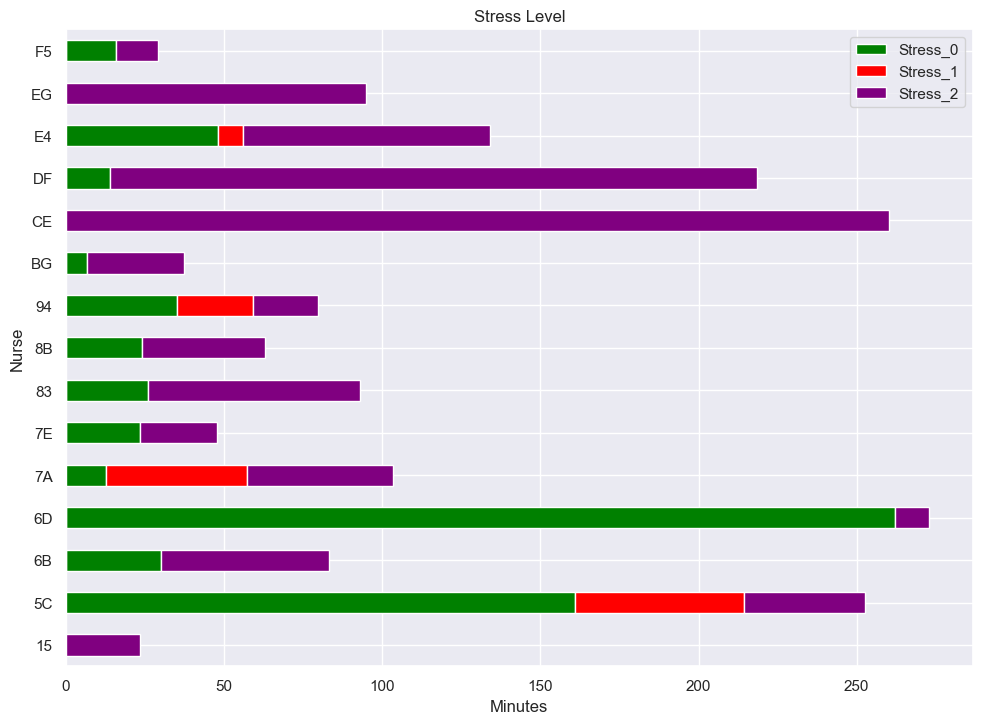

In [10]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
stressLvl.set_index('Nurse').plot(kind='barh', stacked=True, color=['green','red','purple'])
plt.xlabel("Minutes")
plt.title("Stress Level")

#### Description:

If the data shows that certain nurses consistently report high levels of stress, healthcare organizations can work with these individuals to identify the root causes of their stress and develop strategies to manage it. This might include providing stress management training, reducing workload, or offering other forms of support.

Additionally, tracking stress levels over time can provide insights into the effectiveness of interventions and strategies designed to manage stress in nurses. By monitoring the stress levels of nurses before and after implementing these interventions, healthcare organizations can determine whether the interventions are effective and make adjustments as needed.

------
### Box plots of all the measured data of Nurses

In [11]:
#empty DataFrame for the box plot
box_plot_df = pd.DataFrame()

#loop over each unique nurse in the dataset
for nurse in list(combinedDataSurveyAndNurses.Nurse.unique()):
    #current nurse
    currentNurse = combinedDataSurveyAndNurses.loc[combinedDataSurveyAndNurses.Nurse==nurse]
    #if nurse has experienced stress level
    if currentNurse["Stress level"].nunique() > 1:
        currentNurse = currentNurse[["Nurse","Stress level","Temperature","Blood Volume Pulse","Electrodermal Activity","Heart Rate"]]
        box_plot_df = pd.concat([box_plot_df,currentNurse])
my_pal = {stress: "green" if stress == 0 else "red" if stress == 1 else "purple" for stress in box_plot_df["Stress level"].unique()}


---------
### Temperature Measured - Box Plot

Text(0, 0.5, 'Temperature °C')

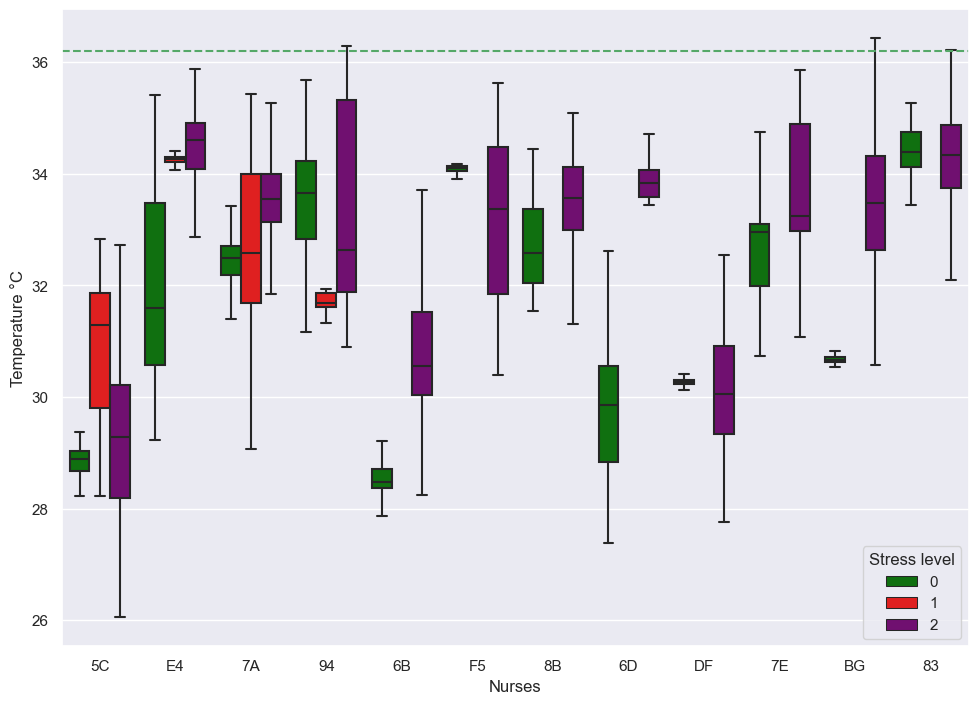

In [12]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='Nurse',y='Temperature',hue='Stress level',data=box_plot_df,palette=my_pal,showfliers = False)
plt.axhline(y=36.2, color='g', linestyle='--')
plt.xlabel("Nurses")
plt.ylabel("Temperature °C")

#### Description

The boxplot shows that nurses with higher stress levels tend to have higher or lower temperature readings than nurses with lower stress levels, it may indicate a relationship between stress and body temperature. This could be useful information for healthcare organizations, as it could indicate that stress is having a physiological impact on nurses and may be contributing to health issues.

---------
### Accelerometer Movement of a Nurse - 3D plot

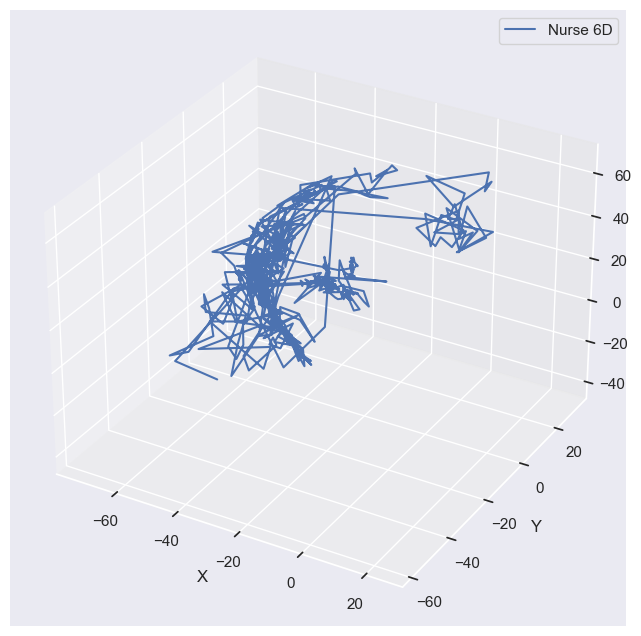

In [13]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

one_nurse = combinedDataSurveyAndNurses.loc[combinedDataSurveyAndNurses.Nurse=="6D"]
one_nurse = one_nurse.loc[one_nurse["Start datetime"] == one_nurse["Start datetime"].iloc[0]]
one_nurse = one_nurse.reset_index(drop=True)
x = one_nurse["ACC_X"]
y = one_nurse["ACC_Y"]
z = one_nurse["ACC_Z"]
ax.plot(x, y, z, label=f'Nurse 6D')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()

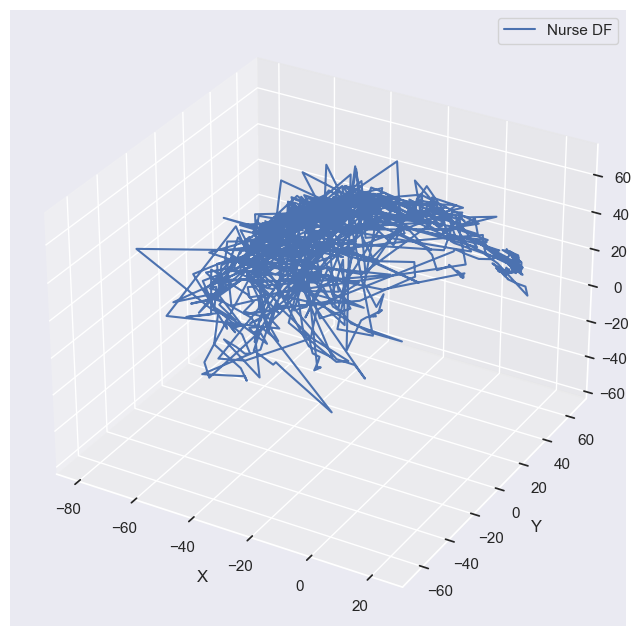

In [14]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

one_nurse = combinedDataSurveyAndNurses.loc[combinedDataSurveyAndNurses.Nurse=="DF"]
one_nurse = one_nurse.loc[one_nurse["Start datetime"] == one_nurse["Start datetime"].iloc[0]]
one_nurse = one_nurse.reset_index(drop=True)
x = one_nurse["ACC_X"]
y = one_nurse["ACC_Y"]
z = one_nurse["ACC_Z"]
ax.plot(x, y, z, label=f'Nurse DF')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()

#### Description:

Accelerometer data can be used to monitor their movements and activity levels during their work shifts. High levels of physical activity, such as walking and lifting, may indicate that the nurse is busy and potentially under stress, while low levels of physical activity may indicate that the nurse is relatively relaxed and not under significant stress.

Additionally, changes in the patterns of movement may also provide insights into the stress levels of nurses. For example, sudden changes in the acceleration patterns, such as rapid or jerky movements, may indicate that the nurse is under stress or experiencing a stressful event.

----------
### Blood volume pulse - Box Plot

Text(0, 0.5, 'Blood Volume Pulse')

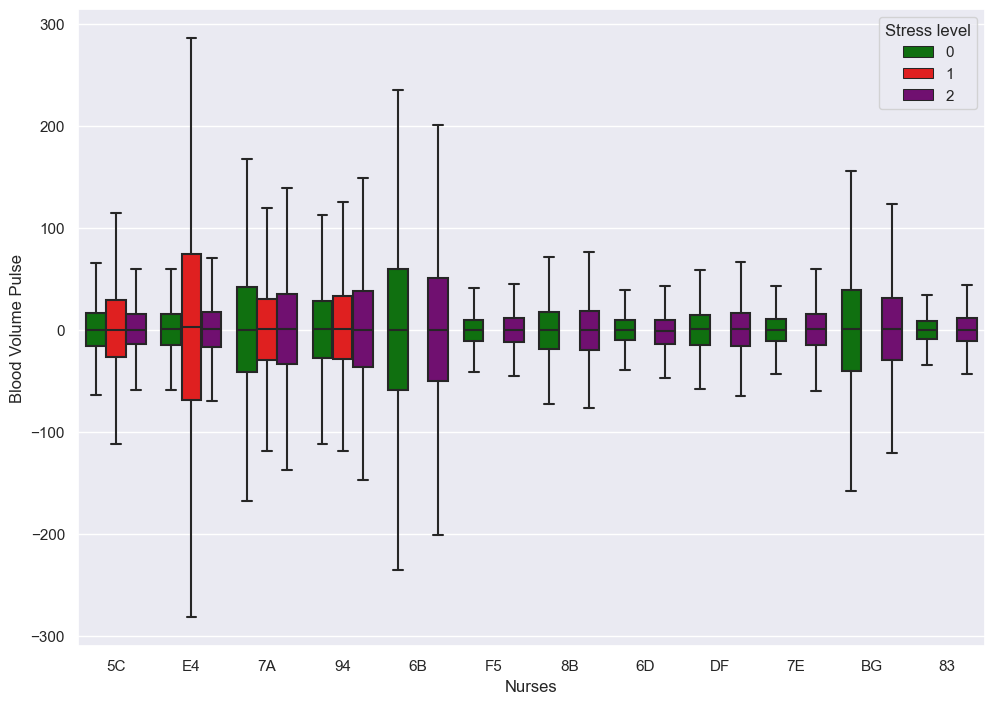

In [15]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='Nurse',y='Blood Volume Pulse',hue='Stress level',data=box_plot_df,palette=my_pal,showfliers = False)
plt.xlabel("Nurses")
plt.ylabel("Blood Volume Pulse")

#### Description:

By comparing the boxplots for each nurse and stress level, you can see whether there are any differences in the distribution of BVP readings between different nurses or stress levels. Similarly, if there are noticeable differences in the spread of BVP readings between nurses or stress levels, this could suggest that some nurses are more susceptible to stress than others, or that certain stress levels have a stronger effect on BVP.

----------
### Heart Rate - Box Plot

Text(0, 0.5, 'Heart Rate')

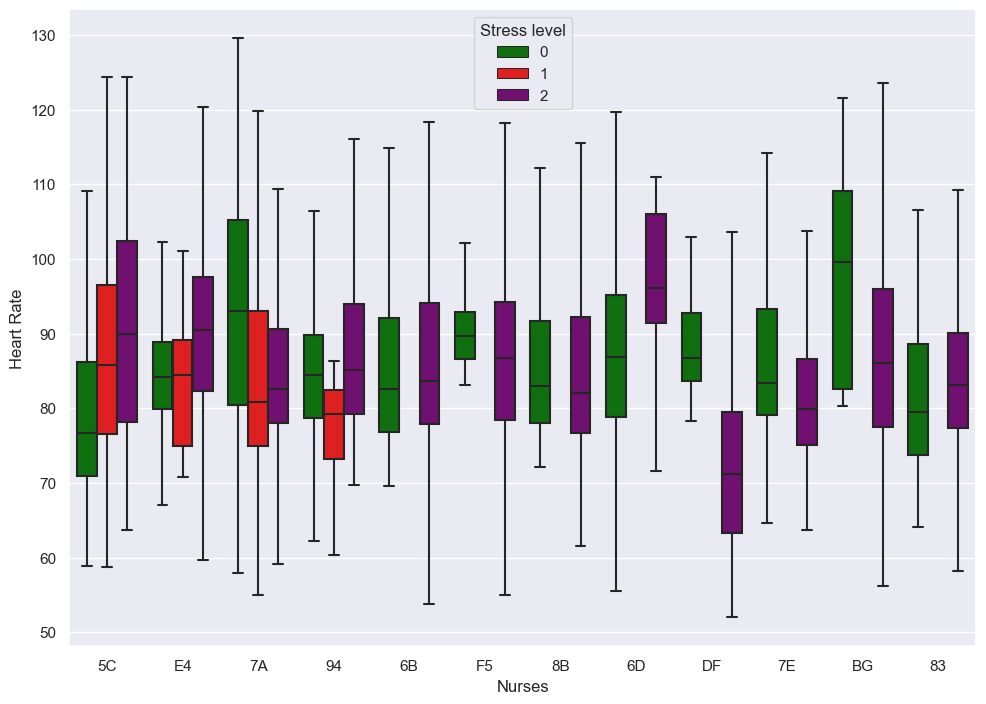

In [16]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='Nurse',y='Heart Rate',hue='Stress level',data=box_plot_df,palette=my_pal,showfliers = False)
plt.xlabel("Nurses")
plt.ylabel("Heart Rate")

#### Description:

Stress can have a significant impact on an individual's physiological functions, including heart rate. By visualizing the Heart Rate distribution of patients across different Nurses and different levels of stress, we can observe any patterns or trends that may indicate a correlation between stress and Heart Rate.

----------
### Electrodermal Activity - Box Plot

Text(0, 0.5, 'Electrodermal Activity')

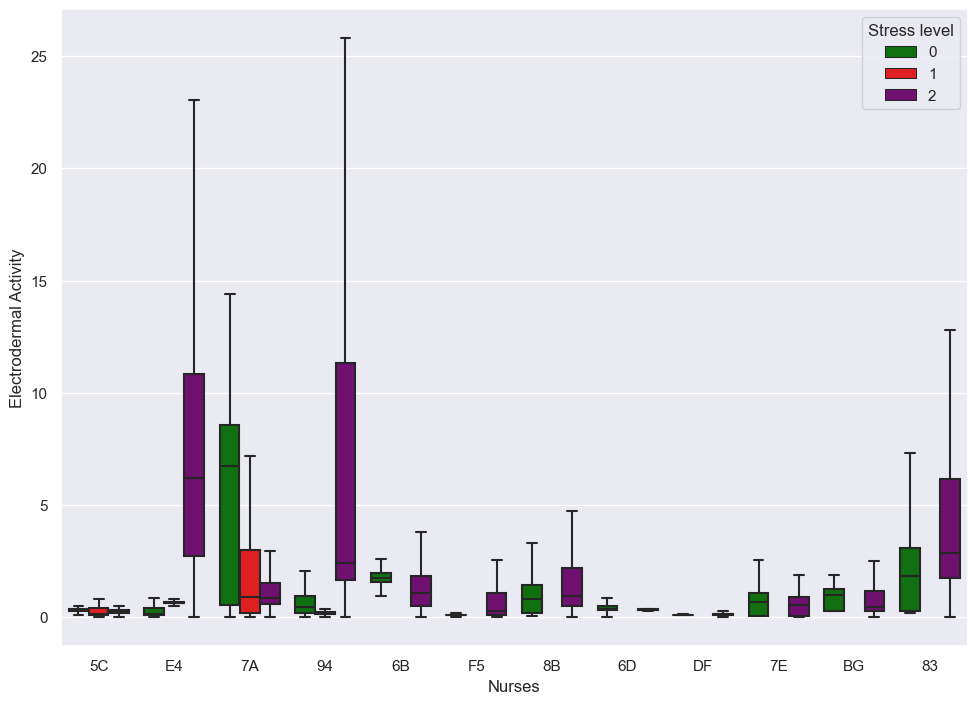

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='Nurse',y='Electrodermal Activity',hue='Stress level',data=box_plot_df,palette=my_pal,showfliers = False)
plt.xlabel("Nurses")
plt.ylabel("Electrodermal Activity")

#### Description:

EDA can be a useful tool for detecting stress in nurses. By monitoring changes in EDA over time, it may be possible to identify when nurses are experiencing high levels of stress, which could then be used to implement interventions to help them manage their stress levels. EDA can also be used in combination with other physiological measures, such as heart rate and blood pressure, to get a more comprehensive picture of a nurse's stress levels.

----------
### Time Series - Temperature over time - Line Plot

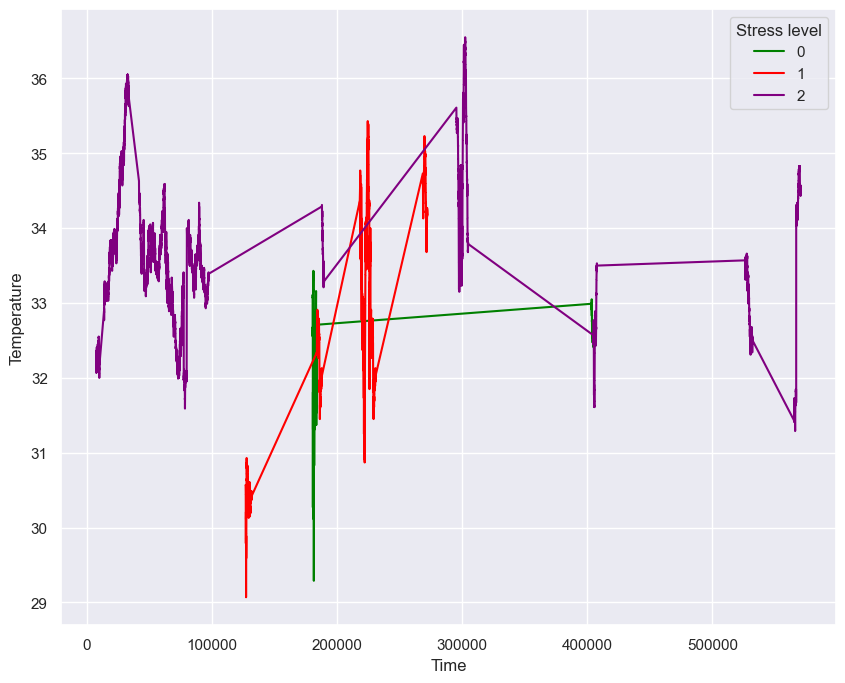

In [18]:
plt.figure(figsize=(10,8))
sns.lineplot(x=combinedDataSurveyAndNurses[combinedDataSurveyAndNurses.Nurse=="7A"].index, y=combinedDataSurveyAndNurses[combinedDataSurveyAndNurses.Nurse=="7A"].Temperature, hue=combinedDataSurveyAndNurses[combinedDataSurveyAndNurses.Nurse=="7A"].loc[:, "Stress level"], palette=my_pal)
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.show()

----------
### Stress w.r.t Temperature - Heat Map

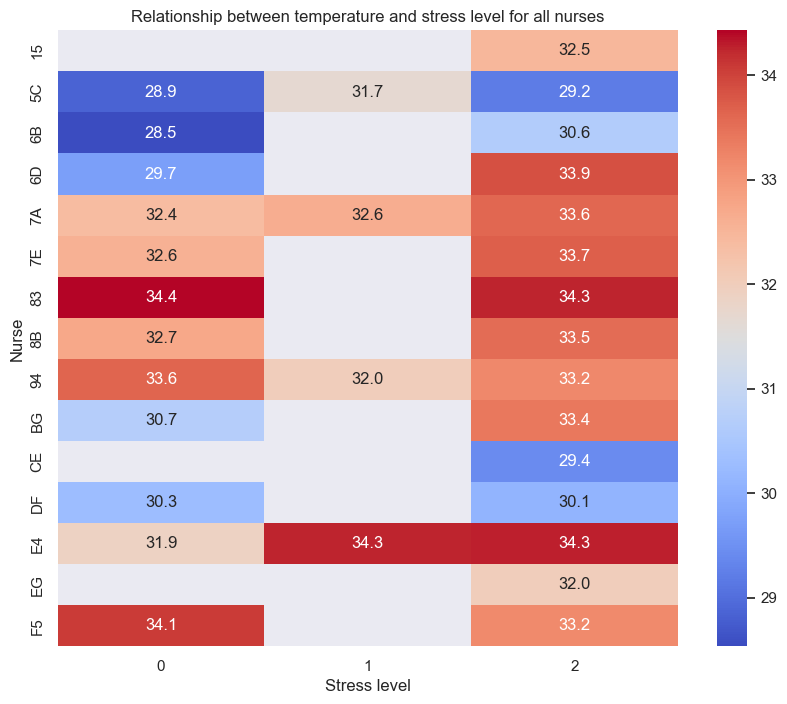

In [19]:
plt.figure(figsize=(10,8))
data = combinedDataSurveyAndNurses.pivot_table(index="Nurse", columns="Stress level", values="Temperature", aggfunc=np.mean)
sns.heatmap(data, cmap="coolwarm", annot=True, fmt=".1f")
plt.title("Relationship between temperature and stress level for all nurses")
plt.xlabel("Stress level")
plt.ylabel("Nurse")
plt.show()


#### Description:

As we can see from the above 2 visualizations that usually at more stress levels the nusrses tend to have less temperature. So that makes temperature an important attribute to detect stress. An increase in body temperature can also be caused by other factors such as illness, hormonal changes, or physical exertion. Therefore, it is important to use temperature measurements in conjunction with other indicators to get a more comprehensive understanding of a nurse's stress levels.

--------------
## Model for feature extraction

In [20]:
modelData = combinedDataSurveyAndNurses.copy()
modelData = modelData.reset_index(drop=True)

#### Calculating Mean, Median and Standard Deviation

In [21]:
for col in ["ACC","Blood Volume Pulse","Electrodermal Activity","Temperature"]:
    temp = modelData.groupby(by=["Nurse","Start datetime","End datetime"])[col].agg([np.nanmean, lambda x: np.nanpercentile(x, 50), np.nanstd])
    temp = temp.reset_index()
    temp.columns = ["Nurse","Start datetime","End datetime", col+"_mean", col+"_median", col+"_SD"]
    modelData = modelData.merge(temp, how="left", on=["Nurse","Start datetime","End datetime"])

In [22]:
modelDataT = modelData.drop(["Datetime","ACC_X","ACC_Y","ACC_Z","ACC","Blood Volume Pulse","Electrodermal Activity","Heart Rate"
                                       ,"Temperature","Date"], axis=1)
modelDataT = modelDataT.drop_duplicates(subset=["Nurse","Start datetime","End datetime"])
modelDataT = modelDataT.drop(["Nurse","Start datetime","End datetime"], axis=1)
modelDataT = modelDataT.reset_index(drop=True)

#simplify the data
modelDataT.loc[modelDataT["Stress level"] == 2.0, "Stress level"] = 1.0

In [23]:
# Stress Level 1 is removed to keep things simpler
# Framing the Problem as Binary Classification Problem

modelDataT.loc[modelDataT["Stress level"] == 2.0,"Stress level"] = 1.0

# Checking for Null Values

isnull = pd.DataFrame(modelDataT.isnull().sum())
isnull.columns=["Missing_Values"]
isnull.T.style.background_gradient(cmap="Blues",high=0.5,low=0.5,axis=1)

In [24]:
#checking No of Examples Per Class
print('No. of rown before resampling')
print('-------------------')
counts = pd.DataFrame(modelDataT["Stress level"].value_counts())
counts.index = counts.index.astype('int64')
counts = counts.rename(columns={"Stress level":"Rows"})
counts.index.name = "Stress level"
print(counts)
counts.T.style.background_gradient(cmap="Blues",high=0.25,low=0.25,axis=1)
print('-------------------')
print('Total: 167 Rows')

#Resampling to balance out
dfNew = resampling(modelDataT)

counts = pd.DataFrame(dfNew["Stress level"].value_counts())
counts.index = counts.index.astype('int64')
counts = counts.rename(columns={"Stress level":"Rows"})
counts.index.name = "Stress level"
counts.T.style.background_gradient(cmap="Blues",high=0.25,low=0.25,axis=1)
print('-------------------')
print('No. of rows after resampling')
print('-------------------')
print(counts)

No. of rown before resampling

-------------------

              Rows

Stress level      

1              136

0               31

-------------------

Total: 167 Rows

-------------------

No. of rows after resampling

-------------------

              Rows

Stress level      

0               80

1               80


-------
## Models

#### SVC

In [25]:
model = SVC(random_state=0)
score = np.mean(cross_val_score(model,dfNew.drop("Stress level",axis=1),dfNew[["Stress level"]],cv=20,scoring="f1",n_jobs=-1))
print("Score: ",round(score,3))

Score:  0.558


#### Random Forest

In [26]:
model = RandomForestClassifier(random_state=0)
score = np.mean(cross_val_score(model,dfNew.drop("Stress level",axis=1),dfNew[["Stress level"]],cv=20,scoring="f1",n_jobs=-1))
print("Score: ",round(score,3))

Score:  0.876


#### Decision Tree

In [27]:
model = DecisionTreeClassifier(random_state=0)
score = np.mean(cross_val_score(model,dfNew.drop("Stress level",axis=1),dfNew[["Stress level"]],cv=20,scoring="f1",n_jobs=-1))
print("Score: ",round(score,3))

Score:  0.852


### Feature Importance

In [28]:
model.fit(dfNew.drop("Stress level",axis=1),dfNew[["Stress level"]])
#feature importances
feat_imp = pd.DataFrame({'Feature': dfNew.drop("Stress level",axis=1).columns,
                         'Importance': model.feature_importances_})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

#top 5 important features
print(feat_imp.head(5))

                        Feature  Importance

18  Electrodermal Activity_mean    0.141290

17        Blood Volume Pulse_SD    0.139436

14                       ACC_SD    0.138143

16    Blood Volume Pulse_median    0.112667

21             Temperature_mean    0.105030


-----------
## Correlation

### Scatterplot Matrix

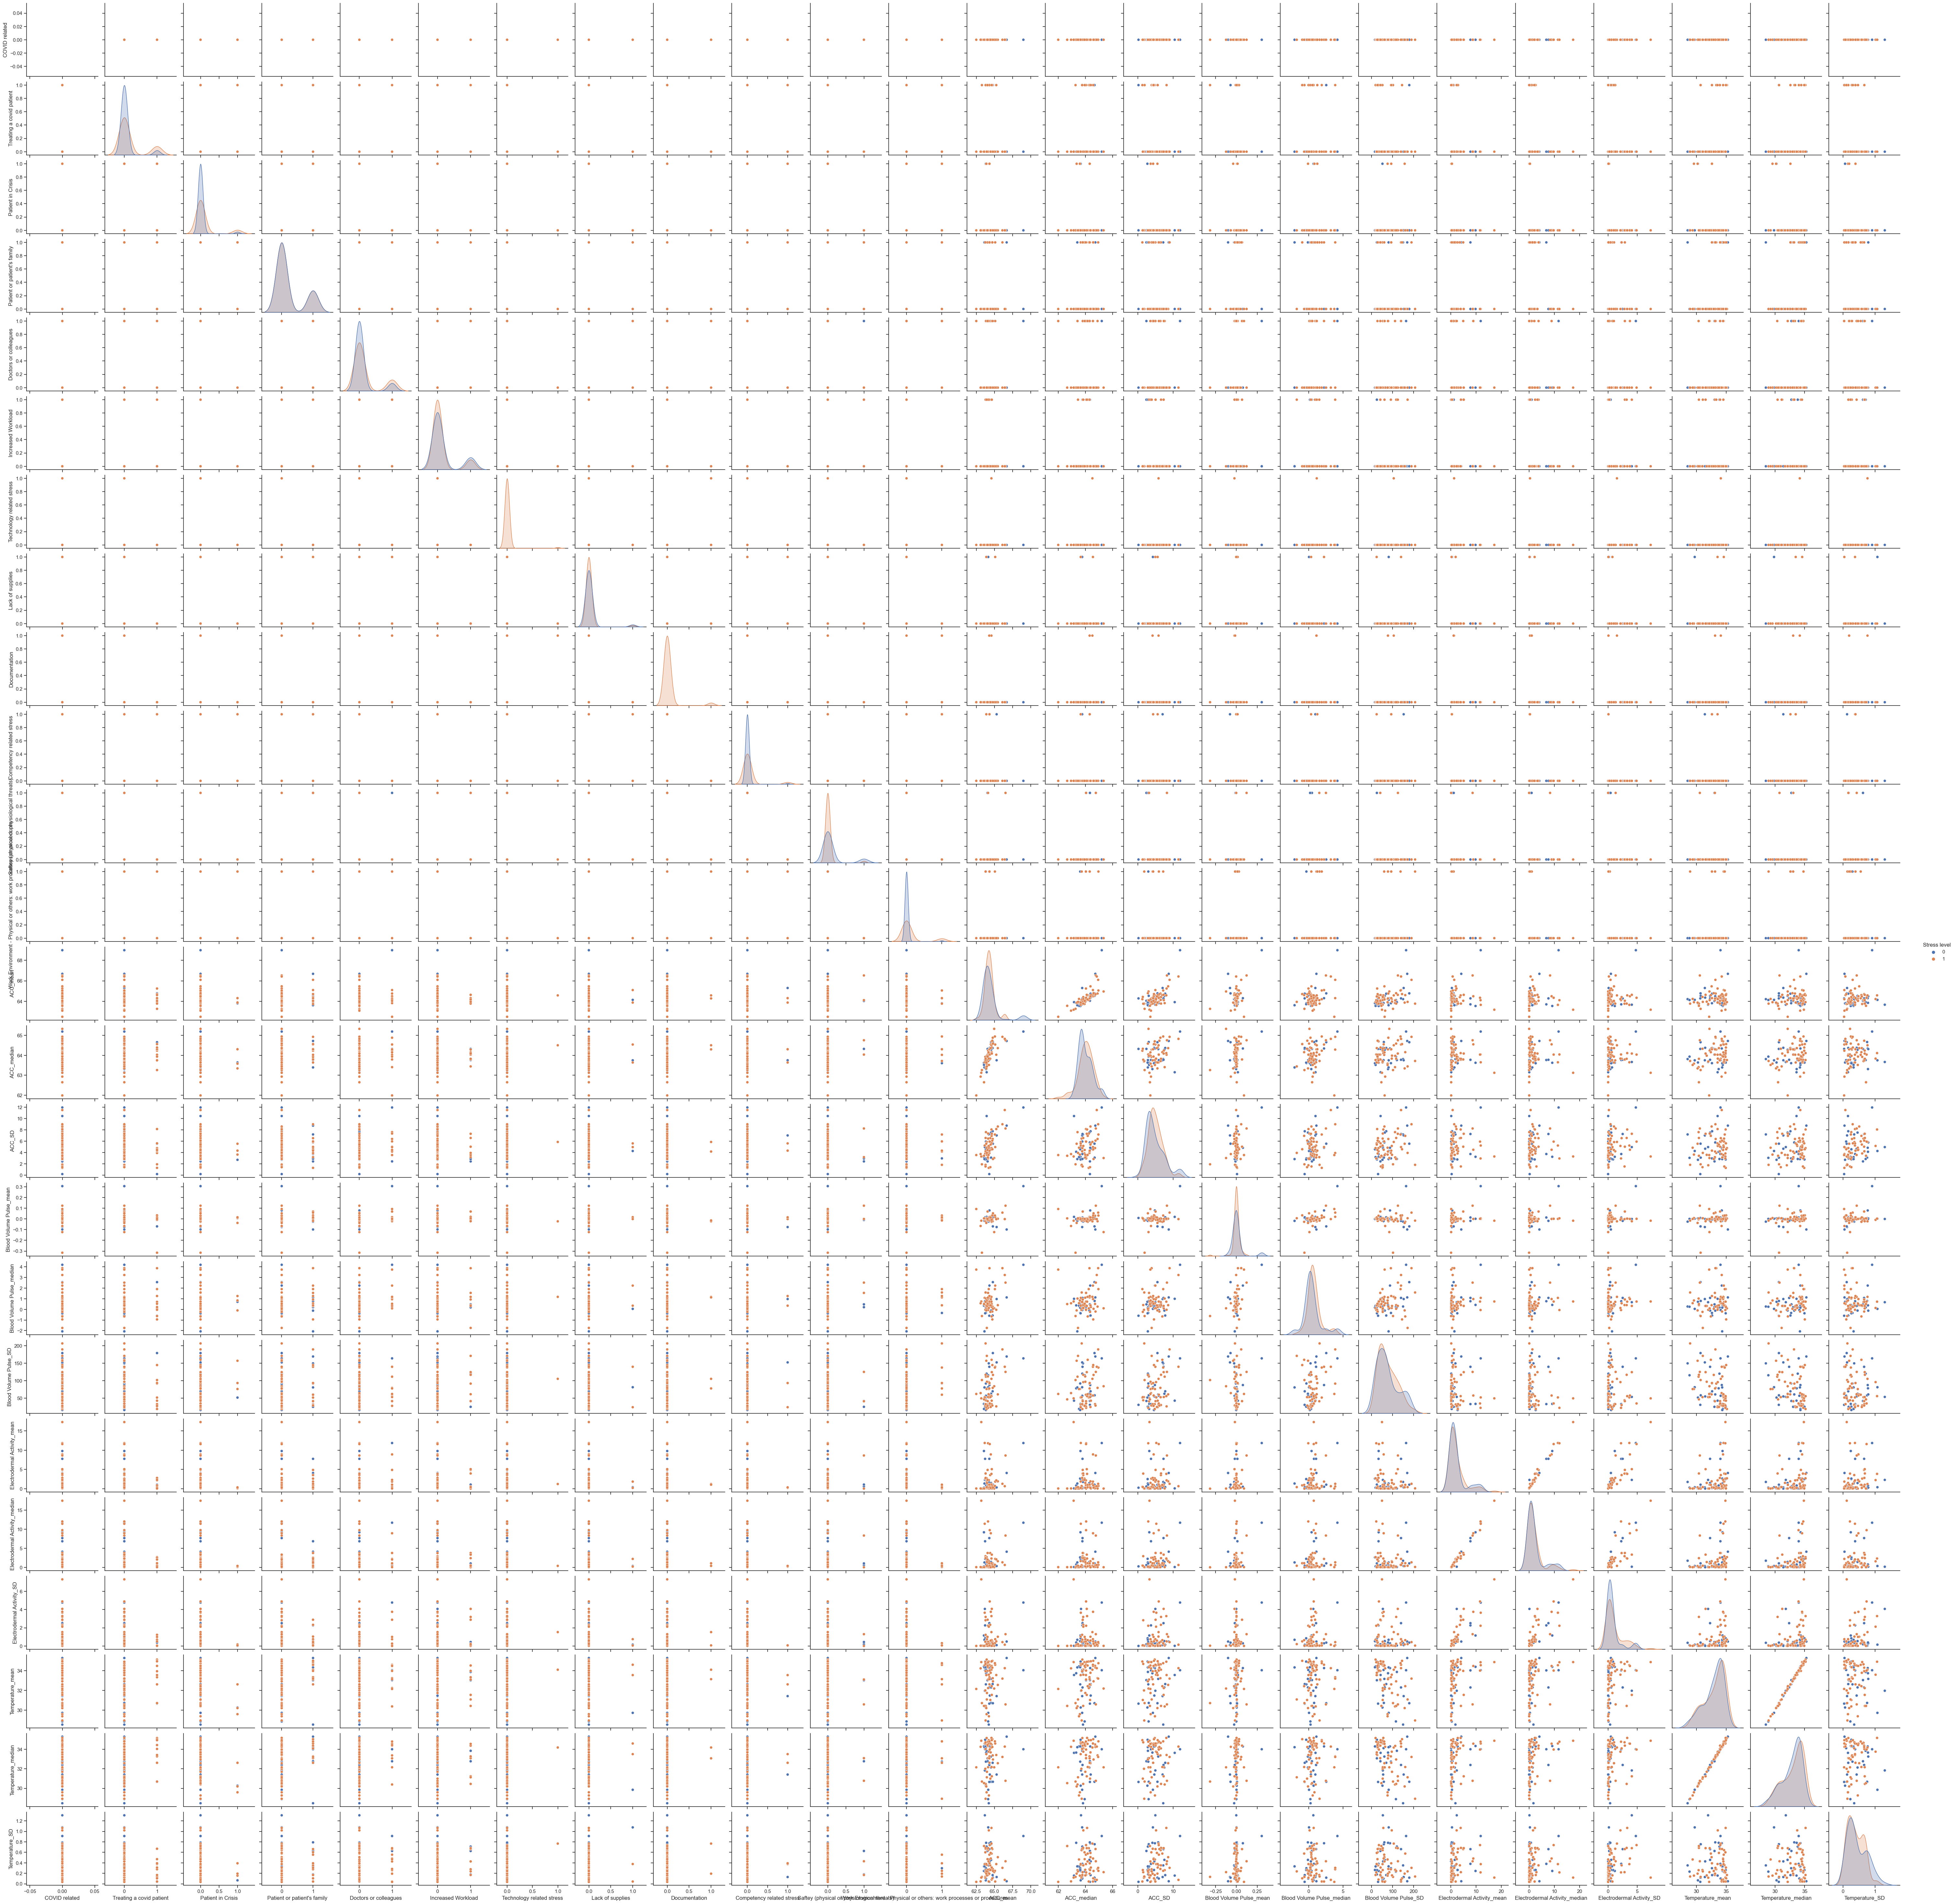

In [29]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(dfNew, hue="Stress level")

### Correlation Heatmap

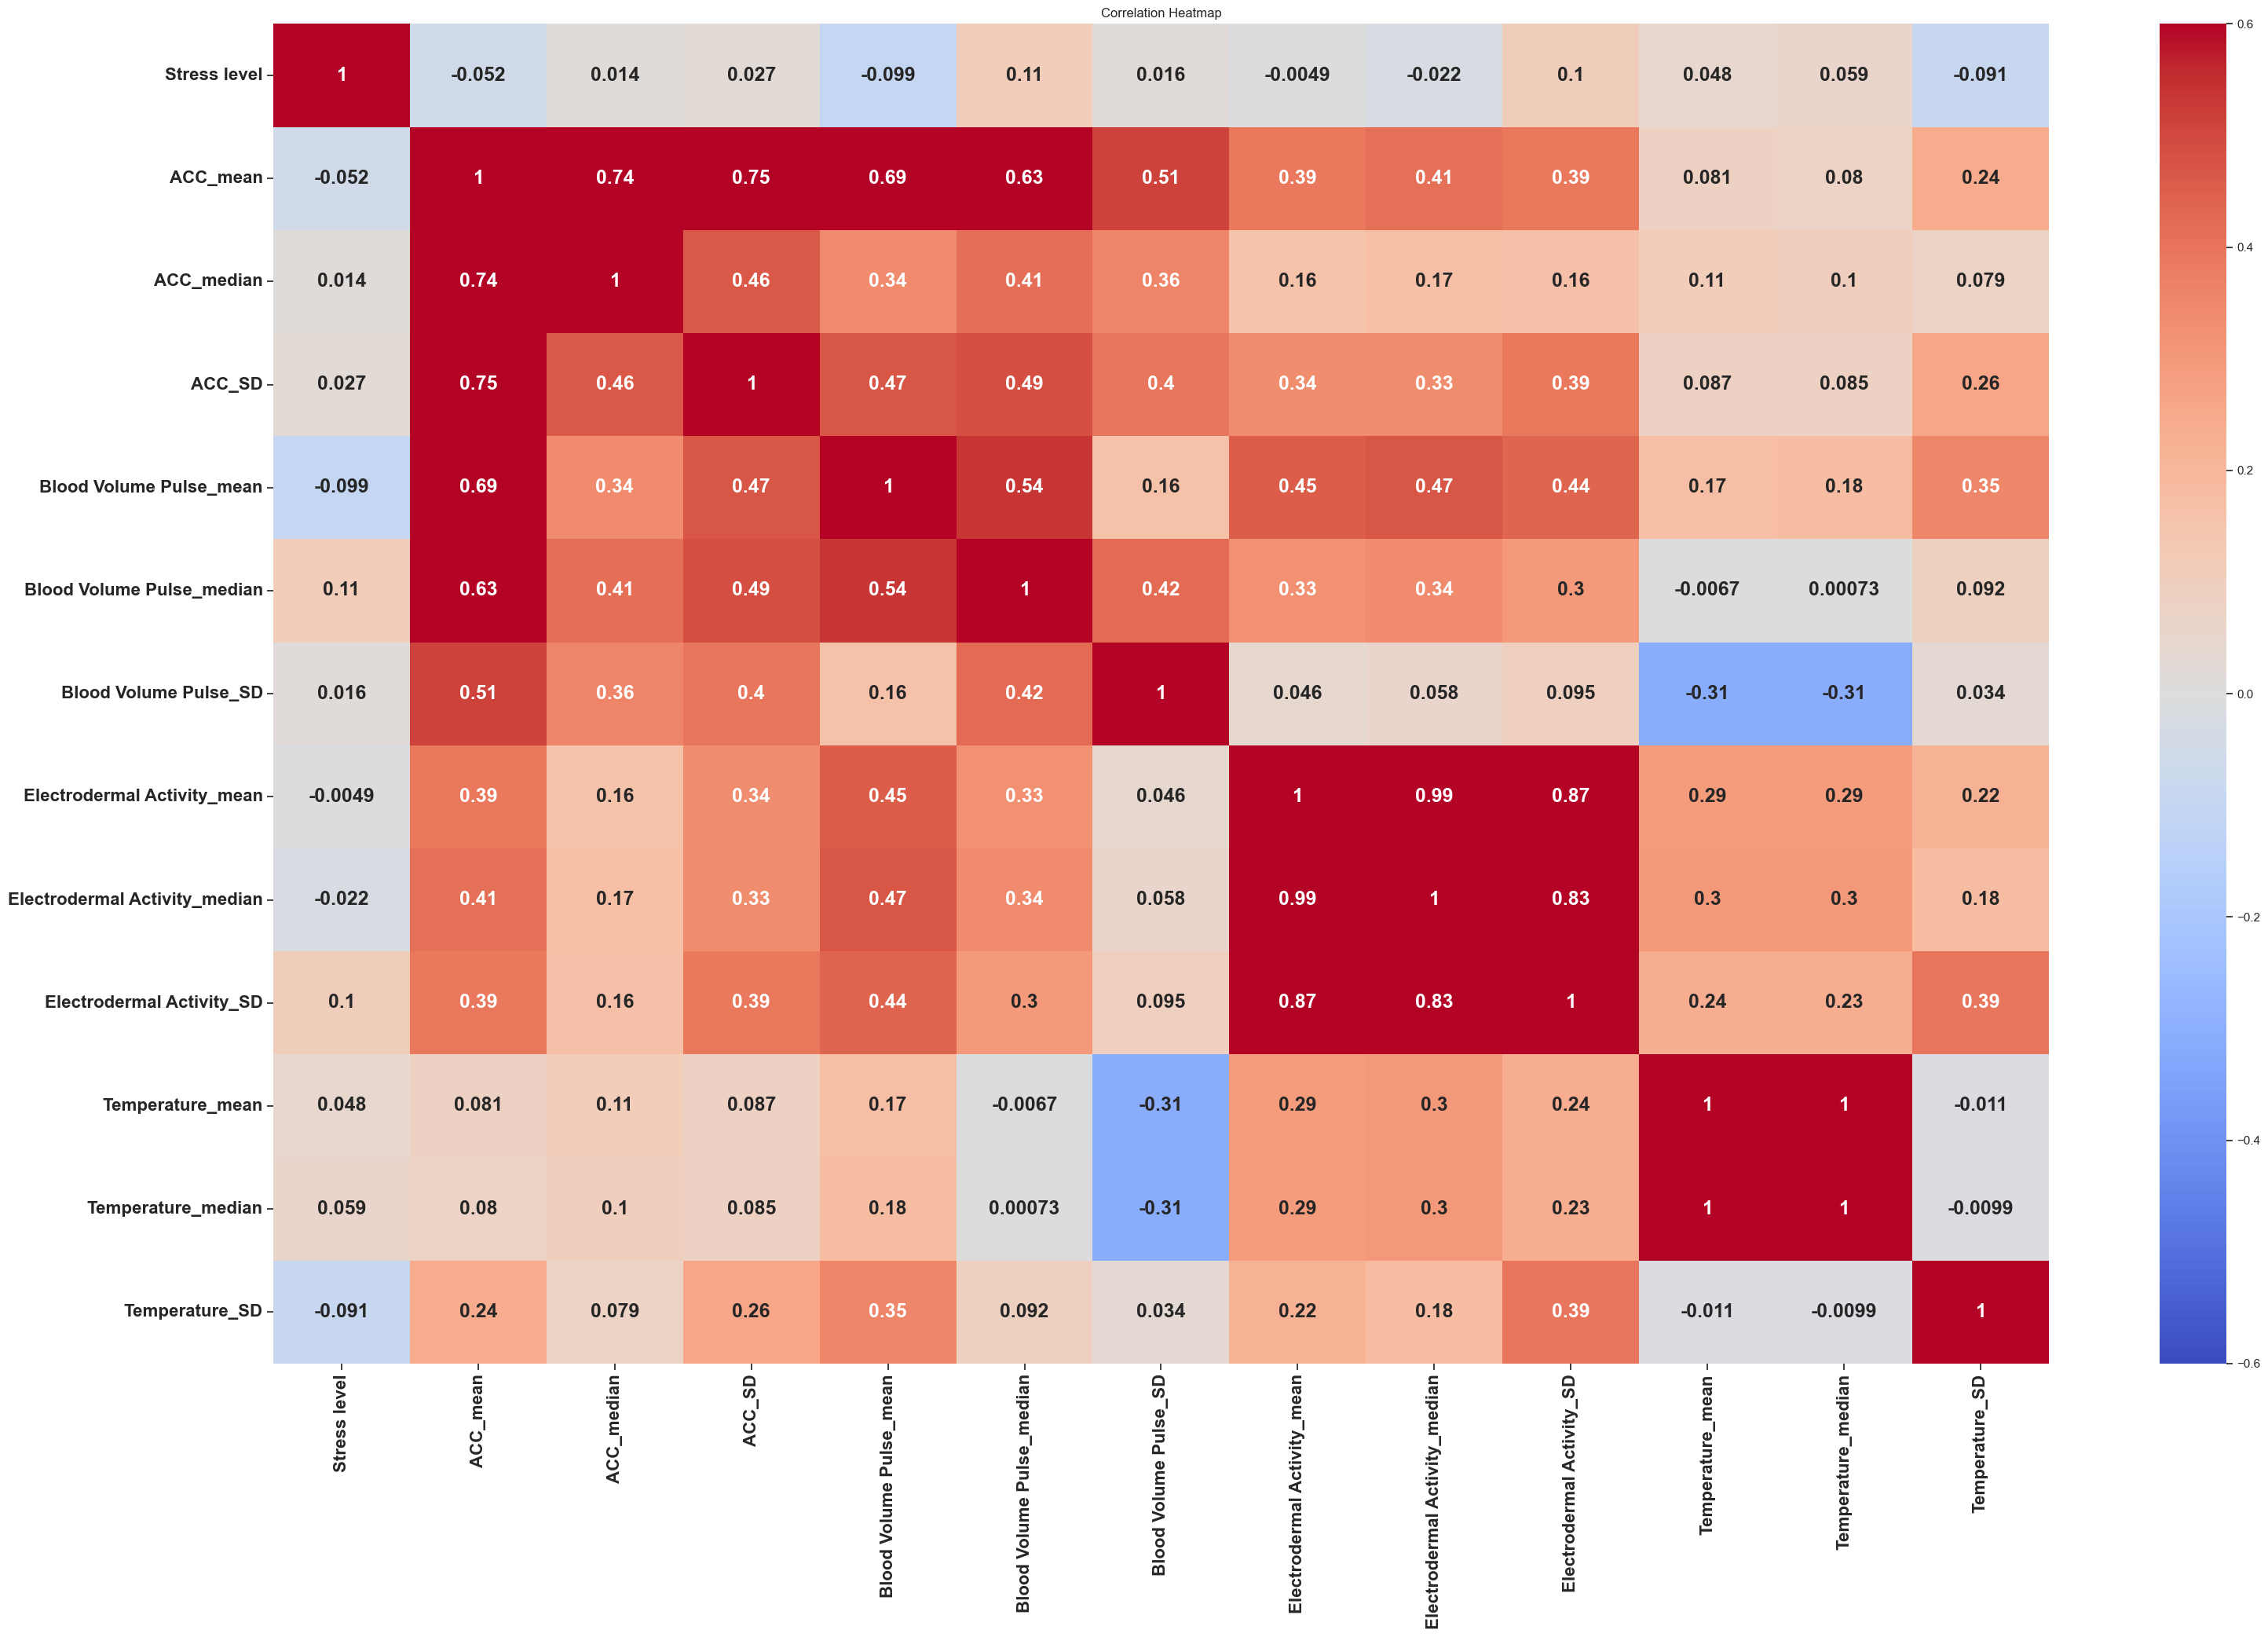

In [30]:
correlation = dfNew[["Stress level"]+list(dfNew.columns[13:])].rename(columns={"Work Environment - Physical or others: work processes or procedures":"Work Environment",
                                                       "Saftey (physical or physiological threats)":"Saftey"}).corr()
plt.figure(figsize=(32,21))
heatmap = sns.heatmap(correlation,annot=True,linewidths=0,vmin=-0.60,vmax=0.60,cmap="coolwarm",annot_kws={"size":18,"weight":"bold"})
for label_x,label_y in zip(heatmap.get_xticklabels(),heatmap.get_yticklabels()):
    label_x.set_weight("bold")
    label_x.set_size(16)
    label_y.set_weight("bold")
    label_y.set_size(16)
plt.title("Correlation Heatmap")
plt.tight_layout()

#### Description:

These helps us understand the relationships between variables in the dataset. By visualizing the correlation between pairs of variables, we can identify which variables are strongly related and which are not. This information can be used to gain insights into the data and inform data analysis or modeling decisions.

------------------
## Test / Train split | 70% - 30%

### Test and Train split is very important. It helps us with:

##### 1. Avoiding Overfitting
##### 2. Measuring Performance
##### 3. Hyperparameter Tuning

In [31]:
X = dfNew.drop("Stress level",axis=1)
Y = dfNew[["Stress level"]]
xTrain,xTest,yTrain,yTest = train_test_split(X,Y,stratify=Y,test_size=0.30,random_state=0)
models = []
scoresIni = []
scoreRfe = []
scoreFinal = []
table = [["X/Y","Train/Test", "Shape"],
         ["X", "Train", xTrain.shape],
         ["Y", "Train", yTrain.shape],
         ["X", "Test", xTest.shape],
         ["Y", "Test", yTest.shape]]
print(tabulate(table, headers="firstrow"))

X/Y    Train/Test    Shape

-----  ------------  ---------

X      Train         (112, 24)

Y      Train         (112, 1)

X      Test          (48, 24)

Y      Test          (48, 1)


## Modeling:

Used one of the most common time series models

### Decision Trees
Decision trees are particularly useful for this problem because they can handle nonlinear relationships between the features and the target variable, which is likely the case for stress detection. Decision trees also allow for easy visualization of the decision-making process, which can help in interpreting the results and identifying important features.

In [32]:
#Initializing the Decision Tree Classifier model
decTreeClsfr = DecisionTreeClassifier(random_state=0)
models.append("Decision Tree Classifier")

print("---------------------------------------------------")
#Calculating the initial score of the model using cross-validation
scoreIni = np.mean(cross_val_score(decTreeClsfr,xTrain,yTrain.values.ravel(),cv=10,scoring="f1",n_jobs=-1))
print("- The Initial Cross-Validation score = ",round(scoreIni,3))

#Training the model on the training data and evaluating its performance on the test data
decTreeClsfr.fit(xTrain,yTrain.values.ravel())
yPred = decTreeClsfr.predict(xTest)
print("- The Initial Test Score = ",round(f1_score(yPred,yTest),3))
scoresIni.append(round(f1_score(yPred,yTest),3))
print("---------------------------------------------------")

#Selecting the best features using Recursive Feature Elimination (RFE) and evaluating the model's performance after feature selection
rfe = RFECV(estimator=decTreeClsfr,step=1,cv=10)
rfe.fit(xTrain,yTrain.values.ravel())
print("- Optimal features: %d" % rfe.n_features_)
print("---------------------------------------------------")
print("- After Feature Selection - Cross-Validation Score = ",round(np.mean(rfe.cv_results_['mean_test_score']),3))
feturesBest = [rfe.feature_names_in_[idx] for idx,x in enumerate(rfe.ranking_) if x ==1]
xTrainBest = xTrain[feturesBest]
xTestBest = xTest[feturesBest]
decTreeClsfr.fit(xTrainBest,yTrain.values.ravel())
yPred = decTreeClsfr.predict(xTestBest)
print("- After Feature Selection - Test score = ",round(f1_score(yPred,yTest),3))
scoreRfe.append(round(f1_score(yPred,yTest),3))

#Optimizing the hyperparameters of the model using Grid Search Cross-Validation (GridSearchCV)
max_depth = range(1,21,1)
criterion = ["gini","entropy"]
max_features = ["sqrt","log2",None]
min_samples_split = range(2,6,1)
min_samples_leaf = range(1,6,1)

#Training the model with the optimized hyperparameters and evaluating its performance on the test data
hyperparameters = dict(criterion=criterion,max_features=max_features,max_depth=max_depth,
                       min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
grid = GridSearchCV(decTreeClsfr,hyperparameters,cv=10,scoring="f1",n_jobs=-1)
best_model = grid.fit(xTrainBest,yTrain.values.ravel())
print("---------------------------------------------------")
print("- After HyperParameter Optimization - F1 Score = ",round(best_model.best_score_,2))
print("---------------------------------------------------")
print("- Parameters =",best_model.best_estimator_.get_params())
decTreeClsfr = DecisionTreeClassifier(**best_model.best_estimator_.get_params())
decTreeClsfr.fit(xTrainBest,yTrain.values.ravel())
Y_pred = decTreeClsfr.predict(xTestBest)
print("---------------------------------------------------")
print("- After Optimizing the Parameters - Test Score = ",round(f1_score(yPred,yTest),3))
scoreFinal.append(round(f1_score(yPred,yTest),3))

---------------------------------------------------

- The Initial Cross-Validation score =  0.729

- The Initial Test Score =  0.837

---------------------------------------------------

- Optimal features: 19

---------------------------------------------------

- After Feature Selection - Cross-Validation Score =  0.76

- After Feature Selection - Test score =  0.864

---------------------------------------------------

- After HyperParameter Optimization - F1 Score =  0.87

---------------------------------------------------

- Parameters = {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'random_state': 0, 'splitter': 'best'}

---------------------------------------------------

- After Optimizing the Parameters - Test Score =  0.864


### Gradient Boosting
Gradient boosting is another ensemble method that combines multiple weak models to create a strong model. In gradient boosting, the models are built sequentially, with each new model attempting to correct the errors of the previous models. Gradient boosting can handle complex relationships between the features and the target variable and has been shown to be particularly effective in handling unbalanced datasets, which is important for the nurse stress detection problem where false negatives are a concern.

In [33]:
# Initializing the Gradient Boosting Classifier model
gradBoostClsfr = GradientBoostingClassifier(random_state=0)
models.append("Gradient Boosting Classifier")

print("---------------------------------------------------")
# Calculating the initial score of the model using cross-validation
scoreIni = np.mean(cross_val_score(gradBoostClsfr, xTrain, yTrain.values.ravel(), cv=10, scoring="f1", n_jobs=-1))
print("- The Initial Cross-Validation score = ", round(scoreIni, 3))

# Training the model on the training data and evaluating its performance on the test data
gradBoostClsfr.fit(xTrain, yTrain.values.ravel())
yPred = gradBoostClsfr.predict(xTest)
print("- The Initial Test Score = ", round(f1_score(yPred, yTest), 3))
scoresIni.append(round(f1_score(yPred, yTest), 3))
print("---------------------------------------------------")

# Selecting the best features using Recursive Feature Elimination (RFE) and evaluating the model's performance after feature selection
rfe = RFECV(estimator=gradBoostClsfr, step=1, cv=10)
rfe.fit(xTrain, yTrain.values.ravel())
print("- Optimal features: %d" % rfe.n_features_)
print("---------------------------------------------------")
print("- After Feature Selection - Cross-Validation Score = ", round(np.mean(rfe.cv_results_['mean_test_score']), 3))
feturesBest = [rfe.feature_names_in_[idx] for idx, x in enumerate(rfe.ranking_) if x == 1]
xTrainBest = xTrain[feturesBest]
xTestBest = xTest[feturesBest]
gradBoostClsfr.fit(xTrainBest, yTrain.values.ravel())
yPred = gradBoostClsfr.predict(xTestBest)
print("- After Feature Selection - Test score = ", round(f1_score(yPred, yTest), 3))
scoreRfe.append(round(f1_score(yPred, yTest), 3))

# Optimizing the hyperparameters of the model using Grid Search Cross-Validation (GridSearchCV)
n_estimators = [100, 500, 1000]
max_depth = [3, 5, 10]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# Training the model with the optimized hyperparameters and evaluating its performance on the test data
hyperparameters = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
                       min_samples_leaf=min_samples_leaf)
grid = GridSearchCV(gradBoostClsfr, hyperparameters, cv=10, scoring="f1", n_jobs=-1)
best_model = grid.fit(xTrainBest, yTrain.values.ravel())
print("---------------------------------------------------")
print("- After HyperParameter Optimization - F1 Score = ", round(best_model.best_score_, 2))
print("---------------------------------------------------")
print("- Parameters =", best_model.best_estimator_.get_params())
gradBoostClsfr = GradientBoostingClassifier(**best_model.best_estimator_.get_params())
gradBoostClsfr.fit(xTrainBest, yTrain.values.ravel())
yPred = gradBoostClsfr.predict(xTestBest)
print("---------------------------------------------------")
print("- After Optimizing the Parameters - Test Score = ", round(f1_score(yPred, yTest), 3))
scoreFinal.append(round(f1_score(yPred, yTest), 3))


---------------------------------------------------

- The Initial Cross-Validation score =  0.77

- The Initial Test Score =  0.762

---------------------------------------------------

- Optimal features: 1

---------------------------------------------------

- After Feature Selection - Cross-Validation Score =  0.757

- After Feature Selection - Test score =  0.818

---------------------------------------------------

- After HyperParameter Optimization - F1 Score =  0.82

---------------------------------------------------

- Parameters = {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 0, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

-----------

### Random Forest
Random forests are an improvement over others because they reduce overfitting and improve the accuracy of the model. Random forests work by building multiple decision trees on random subsets of the data and then combining the predictions of each tree to arrive at a final prediction. Random forests are also able to handle missing data and maintain good performance even when a subset of the features is irrelevant or redundant.

In [34]:
# Initializing the Random Forest Classifier model
rf_clf = RandomForestClassifier(random_state=0)
models.append("Random Forest Classifier")

# Calculating the initial score of the model using cross-validation
scoreIni = np.mean(cross_val_score(rf_clf, xTrain, yTrain.values.ravel(), cv=10, scoring="f1", n_jobs=-1))
print("The Initial Cross-Validation Score is = ", round(scoreIni, 3))

# Test Score
rf_clf.fit(xTrain, yTrain.values.ravel())
yPred = rf_clf.predict(xTest)
print("The Initial Test Score is = ", round(f1_score(yPred, yTest), 3))
scoresIni.append(round(f1_score(yPred, yTest), 3))

# Feature Selection Using Recursive Feature Elimination
rfe = RFECV(estimator=rf_clf, step=1, cv=10)
rfe.fit(xTrain, yTrain.values.ravel())
print("Optimal number of features: %d" % rfe.n_features_)
print("The Cross-Validation Score after Feature Selection is = ", round(np.mean(rfe.cv_results_['mean_test_score']), 3))

feturesBest = [rfe.feature_names_in_[idx] for idx, x in enumerate(rfe.ranking_) if x == 1]
xTrainBest = xTrain[feturesBest]
xTestBest = xTest[feturesBest]
rf_clf.fit(xTrainBest, yTrain.values.ravel())
yPred = rf_clf.predict(xTestBest)
model = RandomForestClassifier(random_state=0)
score = np.mean(cross_val_score(model,dfNew.drop("Stress level",axis=1),dfNew[["Stress level"]],cv=20,scoring="f1",n_jobs=-1))
print("The Test Score after Feature Selection is = ",round(score,3))
scoreRfe.append(round(f1_score(yPred, yTest), 3))

The Initial Cross-Validation Score is =  0.785

The Initial Test Score is =  0.844

Optimal number of features: 1

The Cross-Validation Score after Feature Selection is =  0.775

The Test Score after Feature Selection is =  0.876


## Confusion Matrix
These values can be used to calculate various metrics that are useful for evaluating the model's performance, such as accuracy, precision, recall, and F1 score. By examining the confusion matrix, we can see where the model is making errors and adjust our approach accordingly.

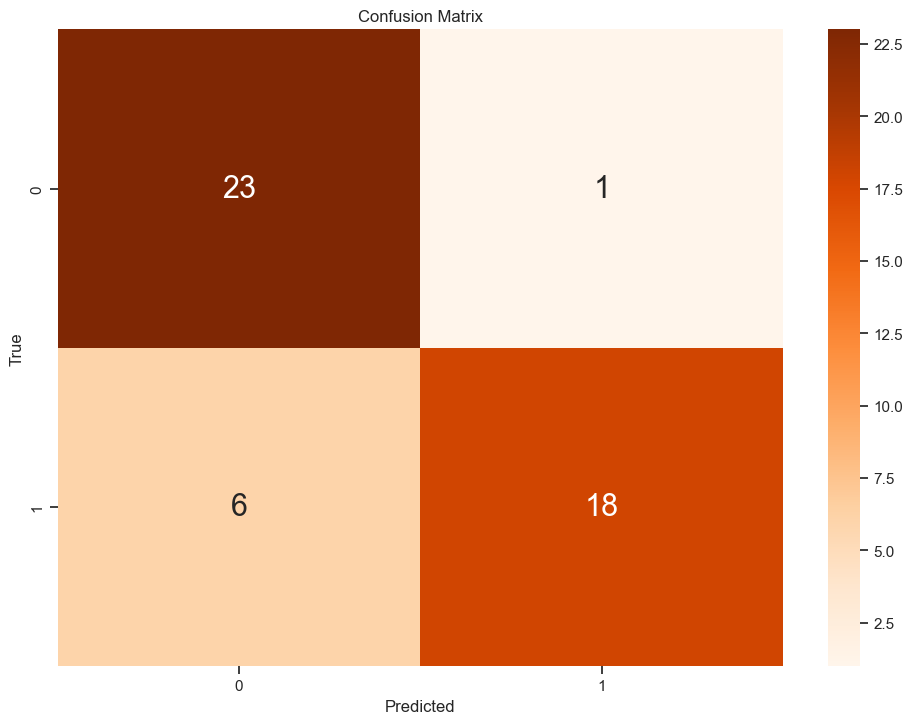

In [35]:
cm = confusion_matrix(yTest, yPred)
sns.heatmap(cm, annot=True, cmap='Oranges', annot_kws={"fontsize":22})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Comparison of the test scores of all the models

In [38]:
#comapring the models
scores = {'Model': ['Decision Tree', 'Gradient Boosting', 'Random Forest'],
          'Initial Score': [0.837, 0.762, 0.844],
          'After Feature Selection': [0.864, 0.818, 0.876]}
df = pd.DataFrame(scores)
df.set_index('Model', inplace=True)
print(df)

                   Initial Score  After Feature Selection

Model                                                    

Decision Tree              0.837                    0.864

Gradient Boosting          0.762                    0.818

Random Forest              0.844                    0.876


## Conclusion

In conclusion, this study suggests that the available sensors in the wearable watch can be utilized for developing a stress detection algorithm, based on the analysis of the Nurse stress dataset and exploration of the sensor data. The findings indicate that some sensors are less important and some sensors are more useful in detecting stress, but limitations such as the small sample size and hospital environment should be considered in the development of the algorithm for a larger population. Nevertheless, the results offer a promising starting point for creating a stress detection algorithm using wearable watch sensors, which could significantly enhance individuals' well-being, especially since it is important for nurses to work under no stress to keep things alright

# THE END